Loading Africa Quantity dataset...
Dataset shape: (219, 35)

First few rows:
  Land Area Trade flow    Commodity  2000 S_2000  2001 S_2001   2002 S_2002  \
0   Algeria     Export  Crustaceans   854    NaN   819    NaN    916    NaN   
1   Algeria     Export         Fish   187    NaN   259    NaN    977    NaN   
2   Algeria     Import  Crustaceans    23    NaN    21    NaN    128    NaN   
3   Algeria     Import         Fish  7434    NaN  7426    NaN  10389    NaN   
4    Angola     Export  Crustaceans   630      F   834      F   1951      F   

    2003  ...   2011  S_2011   2012  S_2012   2013  S_2013   2014  S_2014  \
0    871  ...    411     NaN    286     NaN    219     NaN    218     NaN   
1    307  ...    109     NaN    277     NaN    317     NaN    339     NaN   
2    176  ...   1269     NaN   1619     NaN   1835     NaN   1932     NaN   
3  20923  ...  27081     NaN  26391     NaN  29121     NaN  39576     NaN   
4    346  ...    619       F   1388       F   1609       F   13

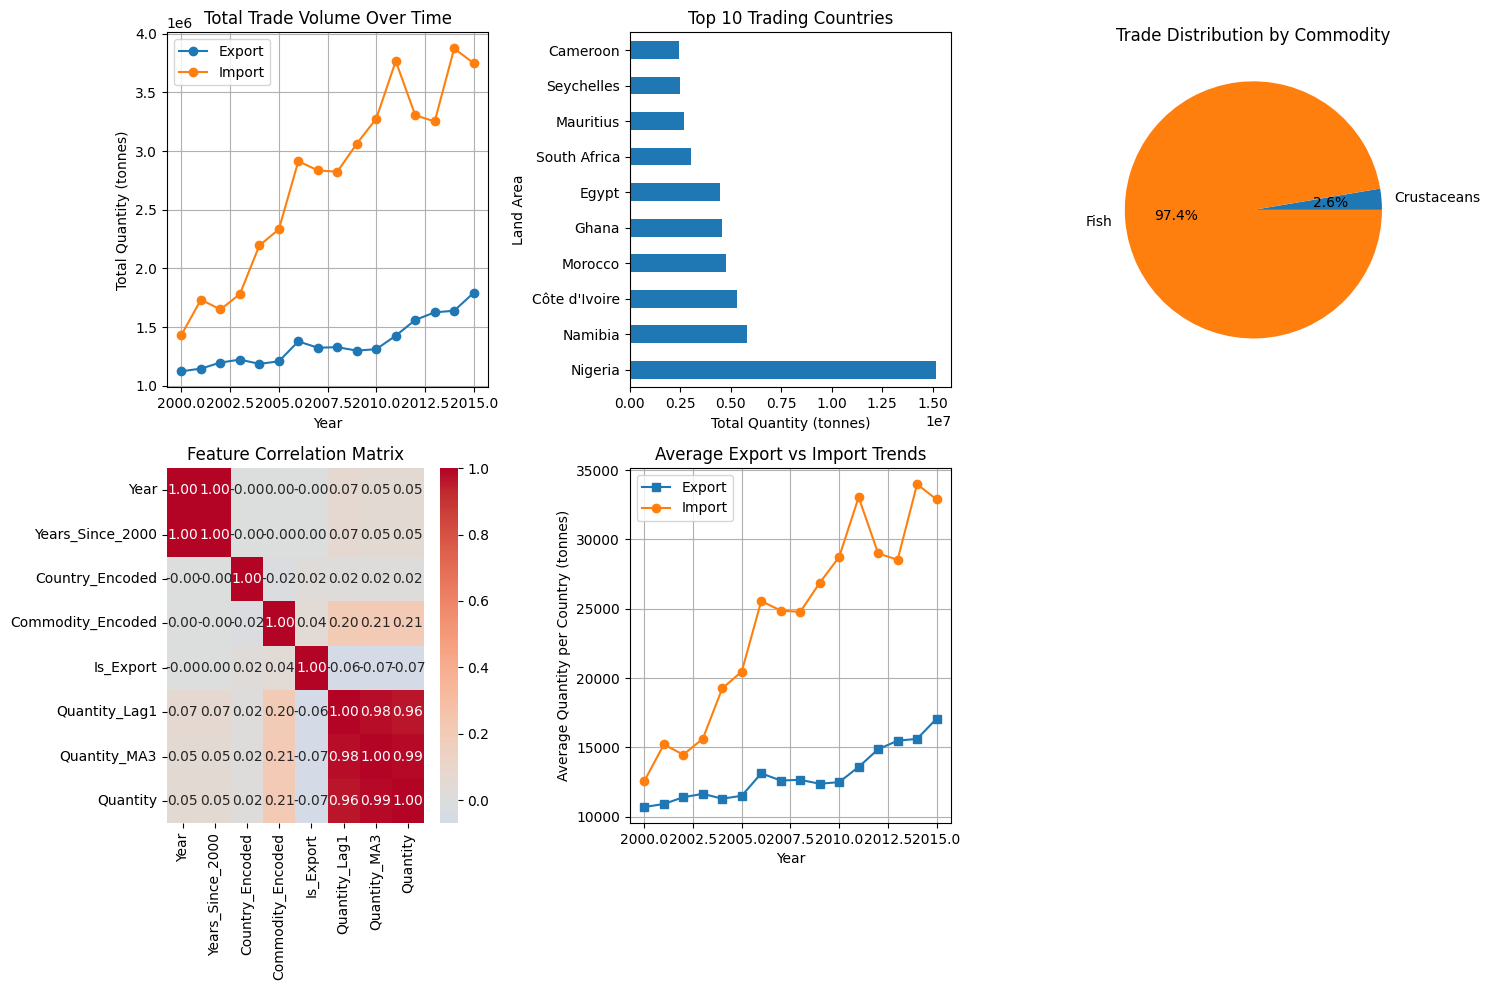


=== PREPARING DATA FOR MODELING ===
Features shape: (3504, 6)
Target shape: (3504,)
Training set size: 2803
Test set size: 701

=== MODEL TRAINING ===

1. Training Linear Regression with Gradient Descent...
Iteration 0, Train Loss: 6278877582.2729
Iteration 100, Train Loss: 5822610435.9610
Iteration 200, Train Loss: 5401760362.2627
Iteration 300, Train Loss: 5013546656.3105
Iteration 400, Train Loss: 4655408124.3523
Iteration 500, Train Loss: 4324985709.9397
Iteration 600, Train Loss: 4020106496.9467
Iteration 700, Train Loss: 3738768980.2430
Iteration 800, Train Loss: 3479129503.5033
Iteration 900, Train Loss: 3239489771.6106

2. Training Scikit-learn Linear Regression...

3. Training Decision Tree...

4. Training Random Forest...

=== MODEL EVALUATION ===

Linear Regression (GD) Performance:
  MSE: 4758140198.4611
  RMSE: 68979.2737
  MAE: 17322.8846
  R² Score: 0.4732

Linear Regression (Sklearn) Performance:
  MSE: 143311214.6210
  RMSE: 11971.2662
  MAE: 2519.4534
  R² Score: 0.9

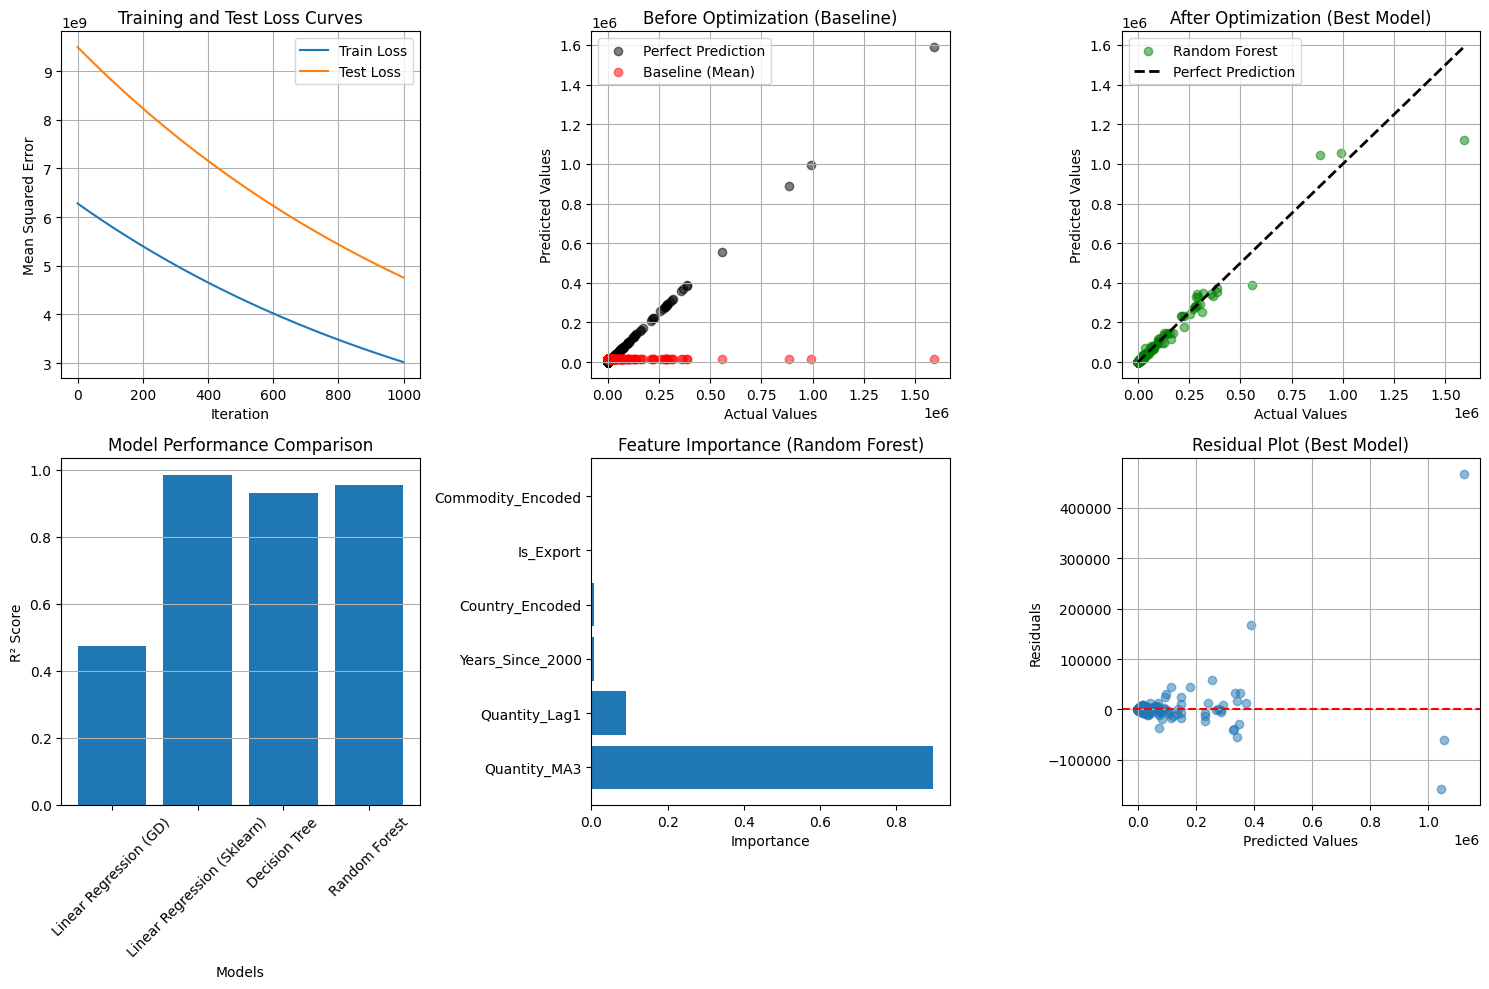


=== SAVING BEST MODEL ===
Best performing model: Linear Regression (Sklearn)
Model and components saved successfully!

=== PREDICTION FUNCTION ===

Testing prediction function...

Predictions for Egypt in 2025:
Export Total: 1255.11 tonnes
Import Total: 2666.38 tonnes

=== ANALYSIS COMPLETE ===
All models trained, evaluated, and saved successfully!
Best model (Linear Regression (Sklearn)) achieved R² score of 0.9841


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
print("Loading Africa Quantity dataset...")
df = pd.read_csv('Africa_Quantity.csv')
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

# Step 1: Data Exploration and Understanding
print("\n=== DATA EXPLORATION ===")
print(f"Unique Trade flows: {df['Trade flow'].unique()}")
print(f"Unique Commodities: {df['Commodity'].unique()}")
print(f"Number of countries: {df['Land Area'].nunique()}")

# Identify year columns
year_columns = [col for col in df.columns if col.isdigit()]
print(f"Years available: {year_columns}")

# Step 2: Data Preprocessing and Reshaping
print("\n=== DATA PREPROCESSING ===")

# Reshape data from wide to long format
df_long = pd.melt(df,
                  id_vars=['Land Area', 'Trade flow', 'Commodity'],
                  value_vars=year_columns,
                  var_name='Year',
                  value_name='Quantity')

# Convert data types
df_long['Year'] = df_long['Year'].astype(int)
df_long['Quantity'] = pd.to_numeric(df_long['Quantity'], errors='coerce')

# Handle missing values
print(f"Missing values before cleaning: {df_long['Quantity'].isna().sum()}")
df_long['Quantity'] = df_long['Quantity'].fillna(0)  # Fill NaN with 0 for trade quantities

# Focus on aquaculture-related commodities
# Based on typical aquaculture products
aquaculture_commodities = ['Fish', 'Crustaceans', 'Molluscs', 'Aquatic plants']
df_aqua = df_long[df_long['Commodity'].isin(aquaculture_commodities)]

print(f"Shape after filtering for aquaculture: {df_aqua.shape}")

# Step 3: Feature Engineering
print("\n=== FEATURE ENGINEERING ===")

# Create additional features
df_aqua['Years_Since_2000'] = df_aqua['Year'] - 2000
df_aqua['Is_Export'] = (df_aqua['Trade flow'] == 'Export').astype(int)

# Encode categorical variables
le_country = LabelEncoder()
le_commodity = LabelEncoder()

df_aqua['Country_Encoded'] = le_country.fit_transform(df_aqua['Land Area'])
df_aqua['Commodity_Encoded'] = le_commodity.fit_transform(df_aqua['Commodity'])

# Create lag features (previous year's quantity)
df_aqua = df_aqua.sort_values(['Land Area', 'Trade flow', 'Commodity', 'Year'])
df_aqua['Quantity_Lag1'] = df_aqua.groupby(['Land Area', 'Trade flow', 'Commodity'])['Quantity'].shift(1)
df_aqua['Quantity_Lag1'] = df_aqua['Quantity_Lag1'].fillna(0)

# Calculate moving averages
df_aqua['Quantity_MA3'] = df_aqua.groupby(['Land Area', 'Trade flow', 'Commodity'])['Quantity'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

print("Features created successfully")

# Step 4: Exploratory Data Analysis (EDA)
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# 1. Trade flow distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
trade_flow_counts = df_aqua.groupby(['Trade flow', 'Year'])['Quantity'].sum().reset_index()
for flow in ['Export', 'Import']:
    data = trade_flow_counts[trade_flow_counts['Trade flow'] == flow]
    plt.plot(data['Year'], data['Quantity'], marker='o', label=flow)
plt.xlabel('Year')
plt.ylabel('Total Quantity (tonnes)')
plt.title('Total Trade Volume Over Time')
plt.legend()
plt.grid(True)

# 2. Top trading countries
plt.subplot(2, 3, 2)
top_countries = df_aqua.groupby('Land Area')['Quantity'].sum().nlargest(10)
top_countries.plot(kind='barh')
plt.xlabel('Total Quantity (tonnes)')
plt.title('Top 10 Trading Countries')
plt.tight_layout()

# 3. Commodity distribution
plt.subplot(2, 3, 3)
commodity_dist = df_aqua.groupby('Commodity')['Quantity'].sum()
plt.pie(commodity_dist.values, labels=commodity_dist.index, autopct='%1.1f%%')
plt.title('Trade Distribution by Commodity')

# 4. Correlation heatmap
plt.subplot(2, 3, 4)
numeric_features = ['Year', 'Years_Since_2000', 'Country_Encoded', 'Commodity_Encoded',
                   'Is_Export', 'Quantity_Lag1', 'Quantity_MA3', 'Quantity']
corr_matrix = df_aqua[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()

# 5. Export vs Import comparison
plt.subplot(2, 3, 5)
export_data = df_aqua[df_aqua['Trade flow'] == 'Export'].groupby('Year')['Quantity'].mean()
import_data = df_aqua[df_aqua['Trade flow'] == 'Import'].groupby('Year')['Quantity'].mean()
plt.plot(export_data.index, export_data.values, label='Export', marker='s')
plt.plot(import_data.index, import_data.values, label='Import', marker='o')
plt.xlabel('Year')
plt.ylabel('Average Quantity per Country (tonnes)')
plt.title('Average Export vs Import Trends')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 5: Prepare data for modeling
print("\n=== PREPARING DATA FOR MODELING ===")

# Remove rows with missing values in features
df_model = df_aqua.dropna()

# Define features and target
feature_columns = ['Years_Since_2000', 'Country_Encoded', 'Commodity_Encoded',
                  'Is_Export', 'Quantity_Lag1', 'Quantity_MA3']
X = df_model[feature_columns]
y = df_model['Quantity']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Step 6: Model Training and Comparison
print("\n=== MODEL TRAINING ===")

# 1. Linear Regression with manual gradient descent implementation
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.losses_train = []
        self.losses_test = []

    def fit(self, X, y, X_test=None, y_test=None):
        # Add intercept term
        X = np.c_[np.ones(X.shape[0]), X]
        if X_test is not None:
            X_test = np.c_[np.ones(X_test.shape[0]), X_test]

        # Initialize weights
        self.theta = np.zeros(X.shape[1])
        m = len(y)

        # Gradient descent
        for i in range(self.n_iterations):
            # Predictions
            y_pred = X.dot(self.theta)

            # Calculate gradients
            gradients = 2/m * X.T.dot(y_pred - y)

            # Update weights
            self.theta -= self.learning_rate * gradients

            # Calculate and store losses
            train_loss = np.mean((y_pred - y)**2)
            self.losses_train.append(train_loss)

            if X_test is not None and y_test is not None:
                test_pred = X_test.dot(self.theta)
                test_loss = np.mean((test_pred - y_test)**2)
                self.losses_test.append(test_loss)

            if i % 100 == 0:
                print(f"Iteration {i}, Train Loss: {train_loss:.4f}")

    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return X.dot(self.theta)

# Train Linear Regression with Gradient Descent
print("\n1. Training Linear Regression with Gradient Descent...")
lr_gd = LinearRegressionGD(learning_rate=0.0001, n_iterations=1000)
lr_gd.fit(X_train_scaled, y_train, X_test_scaled, y_test)

# Predictions
y_pred_lr_gd = lr_gd.predict(X_test_scaled)

# 2. Scikit-learn Linear Regression
print("\n2. Training Scikit-learn Linear Regression...")
lr_sklearn = LinearRegression()
lr_sklearn.fit(X_train_scaled, y_train)
y_pred_lr_sklearn = lr_sklearn.predict(X_test_scaled)

# 3. Decision Tree
print("\n3. Training Decision Tree...")
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# 4. Random Forest
print("\n4. Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Step 7: Model Evaluation
print("\n=== MODEL EVALUATION ===")

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate all models
results = {}
results['Linear Regression (GD)'] = evaluate_model(y_test, y_pred_lr_gd, "Linear Regression (GD)")
results['Linear Regression (Sklearn)'] = evaluate_model(y_test, y_pred_lr_sklearn, "Linear Regression (Sklearn)")
results['Decision Tree'] = evaluate_model(y_test, y_pred_dt, "Decision Tree")
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Step 8: Visualization of Results
print("\n=== VISUALIZING RESULTS ===")

plt.figure(figsize=(15, 10))

# 1. Loss curves
plt.subplot(2, 3, 1)
plt.plot(lr_gd.losses_train, label='Train Loss')
plt.plot(lr_gd.losses_test, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.grid(True)

# 2. Scatter plot - Before optimization (baseline)
plt.subplot(2, 3, 2)
plt.scatter(y_test, y_test, alpha=0.5, label='Perfect Prediction', c='black')
plt.scatter(y_test, np.mean(y_train) * np.ones(len(y_test)), alpha=0.5, label='Baseline (Mean)', c='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Before Optimization (Baseline)')
plt.legend()
plt.grid(True)

# 3. Scatter plot - After optimization
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest', c='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('After Optimization (Best Model)')
plt.legend()
plt.grid(True)

# 4. Model comparison
plt.subplot(2, 3, 4)
model_names = list(results.keys())
r2_scores = [results[model]['r2'] for model in model_names]
plt.bar(model_names, r2_scores)
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

# 5. Feature importance (Random Forest)
plt.subplot(2, 3, 5)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()

# 6. Residual plot
plt.subplot(2, 3, 6)
residuals = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Best Model)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 9: Save the best model
print("\n=== SAVING BEST MODEL ===")

# Determine best model based on R² score
best_model_name = max(results, key=lambda x: results[x]['r2'])
print(f"Best performing model: {best_model_name}")

# Save the best model and necessary components
if best_model_name == 'Random Forest':
    best_model = rf
elif best_model_name == 'Decision Tree':
    best_model = dt
else:
    best_model = lr_sklearn

# Save model and preprocessing components
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_country, 'country_encoder.pkl')
joblib.dump(le_commodity, 'commodity_encoder.pkl')

# Save model metadata
model_metadata = {
    'model_type': best_model_name,
    'features': feature_columns,
    'performance': results[best_model_name],
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}
joblib.dump(model_metadata, 'model_metadata.pkl')

print("Model and components saved successfully!")

# Step 10: Create prediction function
print("\n=== PREDICTION FUNCTION ===")

def predict_aquaculture_trade(country, year, trade_flow='both'):
    """
    Predict aquaculture trade volumes for a given country and year.

    Parameters:
    - country: Name of the African country
    - year: Year for prediction
    - trade_flow: 'export', 'import', or 'both'

    Returns:
    - Dictionary with predictions
    """
    # Load saved components
    model = joblib.load('best_model.pkl')
    scaler = joblib.load('scaler.pkl')
    le_country = joblib.load('country_encoder.pkl')
    le_commodity = joblib.load('commodity_encoder.pkl')

    # Check if country is valid
    if country not in le_country.classes_:
        return {
            'error': f"Country '{country}' not found in training data. Available countries: {', '.join(le_country.classes_)}"
        }

    # Prepare predictions for all commodities
    predictions = {}

    # Define trade flows to predict
    if trade_flow == 'both':
        flows = [0, 1]  # Import and Export
        flow_names = ['Import', 'Export']
    elif trade_flow.lower() == 'export':
        flows = [1]
        flow_names = ['Export']
    else:
        flows = [0]
        flow_names = ['Import']

    for flow, flow_name in zip(flows, flow_names):
        total_quantity = 0
        commodity_predictions = {}

        for commodity in le_commodity.classes_:
            # Create feature vector
            features = pd.DataFrame({
                'Years_Since_2000': [year - 2000],
                'Country_Encoded': [le_country.transform([country])[0]],
                'Commodity_Encoded': [le_commodity.transform([commodity])[0]],
                'Is_Export': [flow],
                'Quantity_Lag1': [0],  # Would need historical data for accurate lag
                'Quantity_MA3': [0]    # Would need historical data for accurate MA
            })

            # Scale features
            features_scaled = scaler.transform(features)

            # Make prediction
            quantity_pred = model.predict(features_scaled)[0]
            quantity_pred = max(0, quantity_pred)  # Ensure non-negative

            commodity_predictions[commodity] = round(quantity_pred, 2)
            total_quantity += quantity_pred

        predictions[flow_name] = {
            'total': round(total_quantity, 2),
            'by_commodity': commodity_predictions
        }

    return {
        'country': country,
        'year': year,
        'predictions': predictions,
        'unit': 'tonnes'
    }

# Test the prediction function
print("\nTesting prediction function...")
test_result = predict_aquaculture_trade('Egypt', 2025)
print(f"\nPredictions for Egypt in 2025:")
print(f"Export Total: {test_result['predictions']['Export']['total']} tonnes")
print(f"Import Total: {test_result['predictions']['Import']['total']} tonnes")

# Create a simplified prediction function for the API
def predict_simple(country, year):
    """Simplified prediction function for API use"""
    result = predict_aquaculture_trade(country, year, 'both')

    if 'error' in result:
        return result

    return {
        'country': country,
        'year': year,
        'export_volume': result['predictions']['Export']['total'],
        'import_volume': result['predictions']['Import']['total'],
        'unit': 'tonnes'
    }

# Save the prediction function
import pickle
with open('prediction_function.pkl', 'wb') as f:
    pickle.dump(predict_simple, f)

print("\n=== ANALYSIS COMPLETE ===")
print("All models trained, evaluated, and saved successfully!")
print(f"Best model ({best_model_name}) achieved R² score of {results[best_model_name]['r2']:.4f}")